In [20]:
import os
import sys

import numpy as np
from copy import deepcopy
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as colors
from hydra import initialize, compose
from glob import glob
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.helpers import pandeia_input, pyhalo
from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.utils import util
from mejiro.analysis import stats

In [21]:
output_dir = os.path.join(array_dir, 'pandeia_noise_residuals')
util.create_directory_if_not_exists(output_dir)
util.clear_directory(output_dir)

In [22]:
lens = SampleStrongLens()

num_pix = 51
side = 5.61
output_size = 45
band = 'F106'
oversample = 5
num_samples = 1e3

# add CDM subhalos; NB same subhalo population for all
realization = util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample.pkl'))
lens.add_subhalos(realization)

model = lens.get_array(num_pix=51 * oversample, side=5.61, band=band)

In [23]:
calc, _ = pandeia_input.build_pandeia_calc(array=model, lens=lens, band=band, num_samples=num_samples)

100%|██████████| 865/865 [00:05<00:00, 145.32it/s]

Point source conversion complete: placed 865 point sources
Estimated calculation time: 0:01:08


In [24]:
all_on, _ = pandeia_input.get_pandeia_image(calc)

Performing Pandeia calculation...
Pandeia calculation complete in 0:01:21


In [25]:
np.save(os.path.join(output_dir, 'all_on'), all_on)

In [26]:
all_on = np.load(os.path.join(output_dir, 'all_on.npy'))

# Turn off cosmic ray noise

In [27]:
crs_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
crs_off_dict = deepcopy(calculation_dict)

crs_off_dict['noise']['crs'] = None
pprint(crs_off_dict)

crs_off_calc['calculation'] = crs_off_dict

crs_off, execution_time = pandeia_input.get_pandeia_image(crs_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, 'crs_off.npy'), crs_off)

{'effects': {'saturation': True},
 'noise': {'crs': None,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': False}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:20
Execution time: 0:01:20


# Turn off detector dark current noise

In [28]:
dark_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
dark_off_dict = deepcopy(calculation_dict)

dark_off_dict['noise']['dark'] = False
pprint(dark_off_dict)

dark_off_calc['calculation'] = dark_off_dict

dark_off, execution_time = pandeia_input.get_pandeia_image(dark_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, 'dark_off.npy'), dark_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': False,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': False}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:21
Execution time: 0:01:21


# Turn off flat-field noise

In [29]:
ffnoise_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
ffnoise_off_dict = deepcopy(calculation_dict)

ffnoise_off_dict['noise']['ffnoise'] = False
pprint(ffnoise_off_dict)

ffnoise_off_calc['calculation'] = ffnoise_off_dict

ffnoise_off, execution_time = pandeia_input.get_pandeia_image(ffnoise_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, 'ffnoise_off.npy'), ffnoise_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': False,
           'readnoise': True,
           'scatter': False}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:21
Execution time: 0:01:21


# Turn off detector read noise

In [30]:
readnoise_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
readnoise_off_dict = deepcopy(calculation_dict)

readnoise_off_dict['noise']['readnoise'] = False
pprint(readnoise_off_dict)

readnoise_off_calc['calculation'] = readnoise_off_dict

readnoise_off, execution_time = pandeia_input.get_pandeia_image(readnoise_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, 'readnoise_off.npy'), readnoise_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': False,
           'scatter': False}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:21
Execution time: 0:01:21


# Turn off Echelle scattering noise

In [31]:
scatter_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
scatter_off_dict = deepcopy(calculation_dict)

scatter_off_dict['noise']['scatter'] = False
pprint(scatter_off_dict)

scatter_off_calc['calculation'] = scatter_off_dict

scatter_off, execution_time = pandeia_input.get_pandeia_image(scatter_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, 'scatter_off.npy'), scatter_off)

{'effects': {'saturation': True},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': False}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:22
Execution time: 0:01:22


# Turn off pixel saturation effects

In [32]:
saturation_off_calc = deepcopy(calc)

calculation_dict = pandeia_input.get_calculation_dict(init=True)
saturation_off_dict = deepcopy(calculation_dict)

saturation_off_dict['effects']['saturation'] = False
pprint(saturation_off_dict)

saturation_off_calc['calculation'] = saturation_off_dict

saturation_off, execution_time = pandeia_input.get_pandeia_image(saturation_off_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, 'saturation_off.npy'), saturation_off)

{'effects': {'saturation': False},
 'noise': {'crs': True,
           'dark': True,
           'excess': False,
           'ffnoise': True,
           'readnoise': True,
           'scatter': False}}
Performing Pandeia calculation...
Pandeia calculation complete in 0:01:21
Execution time: 0:01:21


# Plot residuals

In [33]:
crs_off = np.load(os.path.join(output_dir, 'crs_off.npy'))
dark_off = np.load(os.path.join(output_dir, 'dark_off.npy'))
ffnoise_off = np.load(os.path.join(output_dir, 'ffnoise_off.npy'))
readnoise_off = np.load(os.path.join(output_dir, 'readnoise_off.npy'))
scatter_off = np.load(os.path.join(output_dir, 'scatter_off.npy'))
saturation_off = np.load(os.path.join(output_dir, 'saturation_off.npy'))

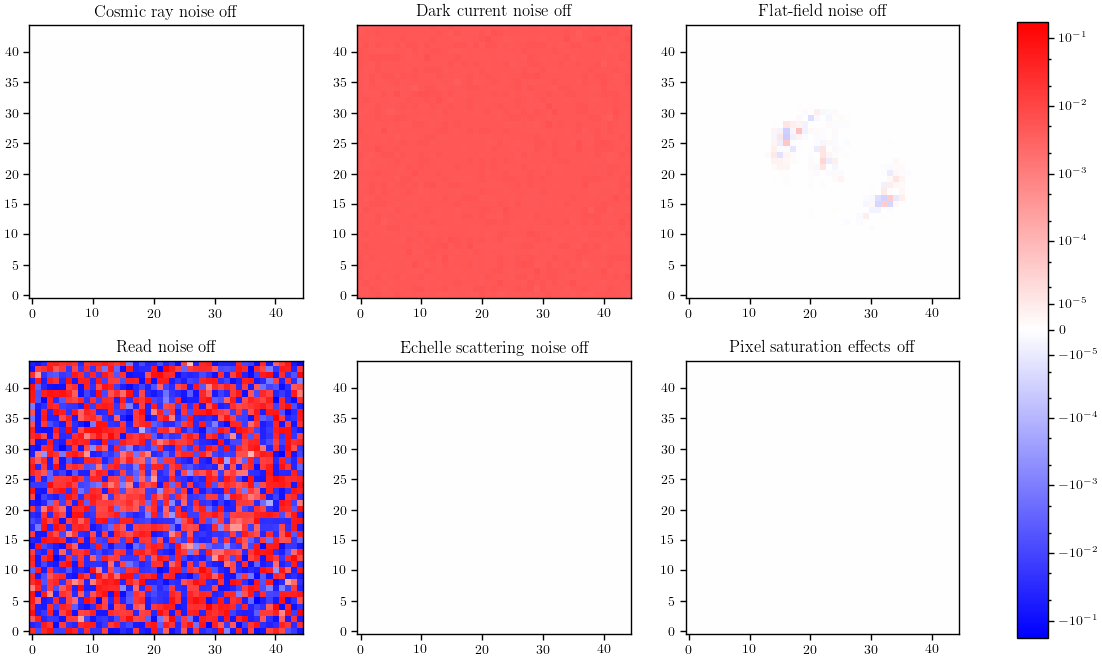

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

array_list = [all_on - crs_off, all_on - dark_off, all_on - ffnoise_off, all_on - readnoise_off, all_on - scatter_off, all_on - saturation_off]

norm = plot_util.get_norm(array_list, linear_width=0.00001)

ax0 = ax[0,0].imshow(all_on - crs_off, cmap='bwr', norm=norm)
ax[0,0].set_title('Cosmic ray noise off')

ax1 = ax[0,1].imshow(all_on - dark_off, cmap='bwr', norm=norm)
ax[0,1].set_title('Dark current noise off')

ax2 = ax[0,2].imshow(all_on - ffnoise_off, cmap='bwr', norm=norm)
ax[0,2].set_title('Flat-field noise off')

ax3 = ax[1,0].imshow(all_on - readnoise_off, cmap='bwr', norm=norm)
ax[1,0].set_title('Read noise off')

ax4 = ax[1,1].imshow(all_on - scatter_off, cmap='bwr', norm=norm)
ax[1,1].set_title('Echelle scattering noise off')

ax5 = ax[1,2].imshow(all_on - saturation_off, cmap='bwr', norm=norm)
ax[1,2].set_title('Pixel saturation effects off')

fig.colorbar(ax0, ax=[ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]])

# plt.savefig(os.path.join(figure_dir, 'noise_asinh.png'))
plt.show()

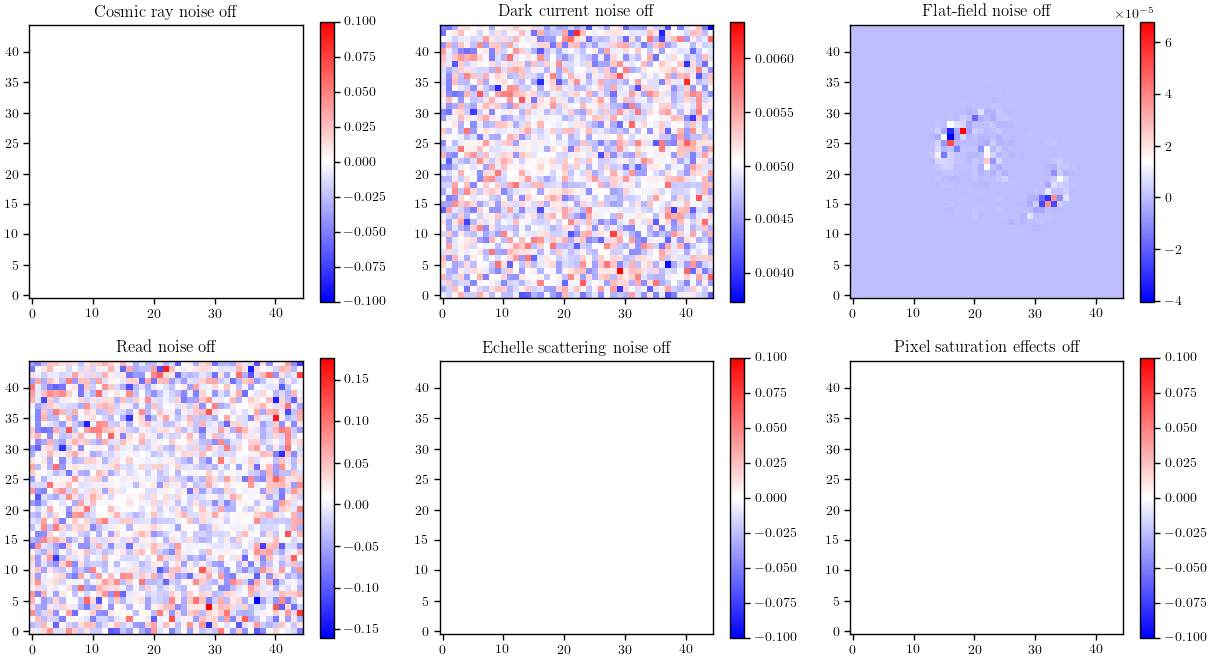

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

array_list = [all_on - crs_off, all_on - dark_off, all_on - ffnoise_off, all_on - readnoise_off, all_on - scatter_off, all_on - saturation_off]

ax0 = ax[0,0].imshow(all_on - crs_off, cmap='bwr')
ax[0,0].set_title('Cosmic ray noise off')

ax1 = ax[0,1].imshow(all_on - dark_off, cmap='bwr')
ax[0,1].set_title('Dark current noise off')

ax2 = ax[0,2].imshow(all_on - ffnoise_off, cmap='bwr')
ax[0,2].set_title('Flat-field noise off')

ax3 = ax[1,0].imshow(all_on - readnoise_off, cmap='bwr')
ax[1,0].set_title('Read noise off')

ax4 = ax[1,1].imshow(all_on - scatter_off, cmap='bwr')
ax[1,1].set_title('Echelle scattering noise off')

ax5 = ax[1,2].imshow(all_on - saturation_off, cmap='bwr')
ax[1,2].set_title('Pixel saturation effects off')

plt.colorbar(ax0, ax=ax[0,0])
plt.colorbar(ax1, ax=ax[0,1])
plt.colorbar(ax2, ax=ax[0,2])
plt.colorbar(ax3, ax=ax[1,0])
plt.colorbar(ax4, ax=ax[1,1])
plt.colorbar(ax5, ax=ax[1,2])

plt.savefig(os.path.join(figure_dir, 'noise_own_colorbars.png'))
plt.show()

In [39]:
print(np.count_nonzero(all_on - crs_off))
print(np.count_nonzero(all_on - scatter_off))
print(np.count_nonzero(all_on - saturation_off))

0
0
0


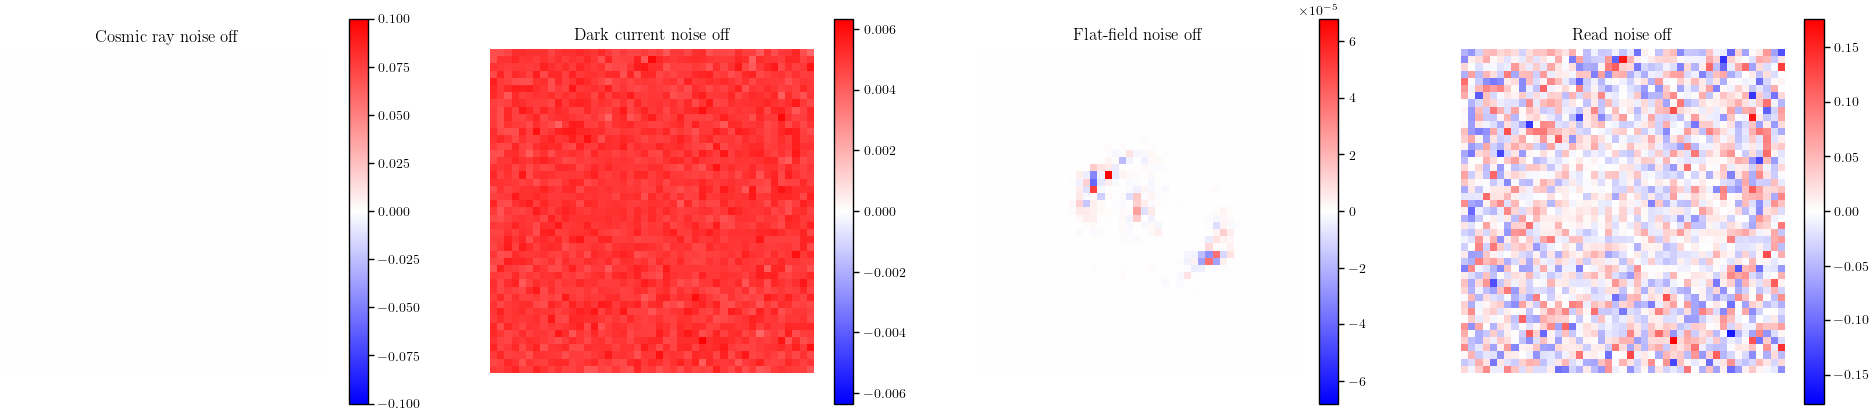

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))

# import matplotlib
# matplotlib.rcParams.update({'font.size': 20})

array_list = [all_on - crs_off, all_on - dark_off, all_on - ffnoise_off, all_on - readnoise_off]
title_list = ['Cosmic ray noise off', 'Dark current noise off', 'Flat-field noise off', 'Read noise off']

for i, array in enumerate(array_list):
    limit = plot_util.get_limit(array)
    axis = ax[i].imshow(array, cmap='bwr', vmin=-limit, vmax=limit)
    ax[i].set_title(title_list[i])
    ax[i].set_axis_off()
    plt.colorbar(axis, ax=ax[i])

plt.savefig(os.path.join(figure_dir, 'noise_own_colorbars.png'))
plt.show()

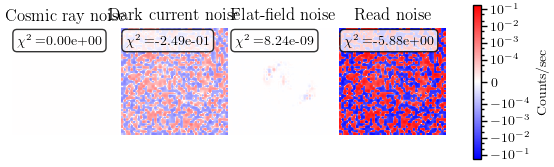

In [38]:
# fontsize = 28
# matplotlib.rcParams.update({'font.size': fontsize})

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(7, 2), gridspec_kw={'wspace': 0.02})

# mean-subtract dark current noise
dark_current_residual = (all_on - dark_off) - np.mean(all_on - dark_off)

array_list = [all_on - crs_off, dark_current_residual, all_on - ffnoise_off, all_on - readnoise_off]
title_list = ['Cosmic ray noise', 'Dark current noise', 'Flat-field noise', 'Read noise']

norm = plot_util.get_norm(array_list, linear_width=0.00001)

for i, array in enumerate(array_list):
    axis = ax[i].imshow(array, cmap='bwr', norm=norm)
    ax[i].set_title(title_list[i])
    ax[i].set_axis_off()

cbar = fig.colorbar(axis, ax=ax, ticks=[-0.1, -0.01, -0.001, -0.0001, 0, 0.0001, 0.001, 0.01, 0.1])
cbar.set_label('Counts/sec', rotation=90)

chi_square_list = []
chi_square_list.append(stats.chi_square(crs_off, all_on))
chi_square_list.append(stats.chi_square(dark_off, all_on))
chi_square_list.append(stats.chi_square(ffnoise_off, all_on))
chi_square_list.append(stats.chi_square(readnoise_off, all_on))
chi_square_list = ['$\chi^2 = $' + util.scientific_notation_string(i) for i in chi_square_list]

# create text boxes
overplot.text_boxes(ax, chi_square_list, alpha=0.8)

plt.savefig(os.path.join(figure_dir, 'noise_asinh.png'))
plt.show()